<a href="https://colab.research.google.com/github/ez314/Fake-Reviews-Project/blob/main/GPT2_Control_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

gpt2 control generation in active development

Future Work
- Categories
  - ~~Infer amazon category name from data~~ Done
  - Randomize order?
  - Prune products without categories?
- Model Robustness
  - ~~Pick an even distribution of ratings, to boost performance of less-common scores like 1.~~ Done, but it doesn't work that well?  
- QoL
  - ~~Use form fields for environment variables~~ Done
  - Seed randomness across the entire model using a global seed
  - Automatically model CG ratings distribution around the calculated OR ratings distribution
- Data Generation
  - Be able to generate review subjects alongside the body
  - ~~Build CG/OR dataset just like in paper 2~~ Done

In [2]:
#@title Configuration Variables

#@markdown Workspace root folder
WORKSPACE = '/content/drive/MyDrive/College/Classes/CS 4v98/CS 4v98 Shared Data/Workspace' #@param {type: "string"}

#@markdown Category name be used in dataset URL replacement
CATEGORY_NAME_URL = 'Automotive' #@param {type: "string"}

#@markdown Category name to be used for save files
CATEGORY_NAME_SIMPLE = "Automotive" #@param {type: "string"}

#@markdown Maximum number of reviews to use from the training set
NUM_REVIEWS =  50000#@param {type: "number"}

#@markdown Number of categories to use
NUM_CATEGORIES =  5#@param {type: "number"}

#@markdown Language Model
MODEL = 'gpt2' #@param ['gpt2']

#@markdown Version to be used for save files
CODE_VER =  6#@param {type: "number"}
#@markdown ---

CODE_VER = f'v{CODE_VER}'

## Python and Env Configuration

#### Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Pip install

In [4]:
!pip install -q transformers sentencepiece
!pip install -q fastai --upgrade

     |████████████████████████████████| 3.8 MB 4.0 MB/s 
     |████████████████████████████████| 1.2 MB 35.6 MB/s 
     |████████████████████████████████| 6.5 MB 43.3 MB/s 
     |████████████████████████████████| 67 kB 5.0 MB/s 
     |████████████████████████████████| 596 kB 39.1 MB/s 
     |████████████████████████████████| 895 kB 47.6 MB/s 
     |████████████████████████████████| 189 kB 4.1 MB/s 
     |████████████████████████████████| 55 kB 3.8 MB/s 


#### Python imports

In [5]:
import os, gzip, json, gc, re, random
from collections import Counter, defaultdict
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoConfig, AutoModelForPreTraining
from fastai.text.all import *

### Set environment and constants

In [6]:
# Set environment variables
%set_env WORKSPACE $WORKSPACE
%set_env CATEGORY_NAME_URL $CATEGORY_NAME_URL
%set_env CATEGORY_NAME_SIMPLE $CATEGORY_NAME_SIMPLE

# Set python constants/configs
SPECIAL_TOKENS  = { "bos_token": "<|BOS|>",
                    "eos_token": "<|EOS|>",
                    "unk_token": "<|UNK|>",
                    "pad_token": "<|PAD|>",
                    "sep_token": "<|SEP|>"}

# Set dir to WORKSPACE
%cd $WORKSPACE

# Initialize numpy RNG
rng = np.random.default_rng()

env: WORKSPACE=/content/drive/MyDrive/College/Classes/CS 4v98/CS 4v98 Shared Data/Workspace
env: CATEGORY_NAME_URL=Automotive
env: CATEGORY_NAME_SIMPLE=Automotive
/content/drive/MyDrive/College/Classes/CS 4v98/CS 4v98 Shared Data/Workspace


## Load Data

### [Skip after first time] Fetch data from source, process, and save

#### Download and extract data

In [12]:
%%bash

download_and_extract() {
  local filename=`basename "$1"`
  local filename_ex=${filename%.gz}

  # Extract file if json not there
  if [ ! -f "$filename_ex" ]
  then
    # Download original file if not there
    if [ ! -f "$filename" ]
    then
      echo "Downloading $filename"
      wget -q "$1"
    fi
    echo "Extracting to $filename_ex"
    gzip -d "$filename"
  else
    echo "Nothing to do: $filename_ex already exists"
  fi
}

download_and_extract "http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/"$CATEGORY_NAME_URL".json.gz"
download_and_extract "http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_"$CATEGORY_NAME_URL".json.gz"

Nothing to do: Automotive.json already exists
Nothing to do: meta_Automotive.json already exists


#### Load all metadata into memory

In [37]:
%%time

# Load unzpped metadata into memory
metadata = {}
useless_categories = None
with open(f'meta_{CATEGORY_NAME_URL}.json') as f:
  counter = 0
  for l in f:
    counter += 1
    if counter % 100000 == 0:
      print(f'Loading item number {counter}')
    j = json.loads(l.strip())

    # Ensure category is list of str
    # if type(j['category']) is not list or any(type(x) is not str for x in j['category']):
    #   print('uh oh!', j)

    # Remove any surrounding spaces from the category
    category = [x.strip() for x in j['category']]

    # Only load fields you will use! Otherwise, memory usage is extremely high.
    metadata[j['asin']] = {
        'title': j['title'],
        'category': category
    }

    # Track useless categories
    if category: 
      if useless_categories is None:
        useless_categories = set(category)
      else:
        useless_categories = useless_categories & set(category)


# Convert categories to string, after removing any useless ones
if useless_categories is None:
  useless_categories = set()
for m in metadata.values():
  filtered_categories = list(filter(lambda x: x not in useless_categories, m['category']))
  fixed_size_categories = (
      filtered_categories[:NUM_CATEGORIES] + 
      [SPECIAL_TOKENS['unk_token']] * max(0, NUM_CATEGORIES - len(filtered_categories))
  )
  m['category'] = SPECIAL_TOKENS['sep_token'].join(fixed_size_categories)

# total length of list, this number equals total number of products
print(f'Loaded {len(metadata)} items')
print(f'Pruned useless categories: {", ".join(useless_categories)}')


Loading item number 100000
Loading item number 200000
Loading item number 300000
Loading item number 400000
Loading item number 500000
Loading item number 600000
Loading item number 700000
Loading item number 800000
Loading item number 900000
Loaded 924693 items
Pruned useless categories: Automotive
CPU times: user 3min 2s, sys: 22.8 s, total: 3min 25s
Wall time: 4min 54s


#### Load all reviews into memory

In [44]:
# Build training data and store to reviews (defaultdict of rating -> list(review))
reviews = defaultdict(list)
with open(f'{CATEGORY_NAME_URL}.json') as f:
  i = 0
  for l in f:
    j = json.loads(l.strip())

    # Filter unusable reviews
    if 'summary' not in j or 'reviewText' not in j or j['asin'] not in metadata:
      continue

    # Increment counter, break if loaded enough reviews, print progress
    # "Enough" defined as NUM_REVIEWS*20, tolerates each category making up >= 5% of reviews
    i += 1
    if i > NUM_REVIEWS * 10:
      break
    if i % 500000 == 0:
      print(f'Loading review number {i}')

    prod_meta = metadata[j['asin']]
    rating = str(int(j["overall"]))

    # Why not build the string right now? Uses too much memory :(
    # Track relevant info for each review
    reviews[rating].append((j['asin'], rating, j['reviewText']))

Loading review number 500000


#### Take an even distribution of reviews from each rating

In [46]:
# Keep track of which product ASINs we haven't looked at. These are guaranteed to not appear in training data
unseen_asins = set(metadata.keys())

# Calculate how many reviews we want to look at
NUM_REVIEWS_PER_RATING = NUM_REVIEWS // len(reviews.keys())

# Build dataframe of actual training set
all_reviews = []
ratings = list(reviews.keys())
for rating in ratings:
  print(f'Sampling {NUM_REVIEWS_PER_RATING}/{len(reviews[rating])} reviews with rating of {rating}.')

  # Pick NUM_REVIEWS_PER_RATING ratings at random to include
  for asin, rating, reviewText in random.sample(reviews[rating], NUM_REVIEWS_PER_RATING):
    prod_meta = metadata[asin]
    all_reviews.append((        
        SPECIAL_TOKENS['bos_token'] + prod_meta['title'] + \
        SPECIAL_TOKENS['sep_token'] + prod_meta['category'] + \
        SPECIAL_TOKENS['sep_token'] + rating + \
        SPECIAL_TOKENS['sep_token'] + reviewText + \
        SPECIAL_TOKENS['eos_token']
    ))
    # Track products which are not in the training data
    if asin in unseen_asins:
      unseen_asins.remove(asin)

all_reviews = pd.DataFrame(all_reviews, columns=["reviewText"])
all_reviews.to_csv(f'{CATEGORY_NAME_SIMPLE}_processed_{CODE_VER}.csv', index=False)

Sampling 10000/344584 reviews with rating of 5.
Sampling 10000/29586 reviews with rating of 3.
Sampling 10000/36233 reviews with rating of 1.
Sampling 10000/71775 reviews with rating of 4.
Sampling 10000/17822 reviews with rating of 2.


#### Manual inspection

In [47]:
all_reviews.head() # Make sure the data looks right

,reviewText
0,"<|BOS|>Meguiar's M6732 Marine/RV One Step Compound, 32 oz<|SEP|>Car Care<|SEP|>Exterior Care<|SEP|>Car Polishes & Waxes<|SEP|>Chrome & Metal Polishes<|SEP|>Metal Polishes<|SEP|>5<|SEP|>Good product<|EOS|>"
1,"<|BOS|>Fel-Pro VS50461R Valve Cover Set<|SEP|>Replacement Parts<|SEP|>Gaskets<|SEP|>Valve Cover & Stem<|SEP|>Valve Cover Gasket Sets<|SEP|><|UNK|><|SEP|>5<|SEP|>6 months ago I got this, and it still protecting from leaks. a bit hard to fit (one cover was a bit longer) but nothing to worry about.<|EOS|>"
2,<|BOS|>Dupli-Color NGGM516 Gold Metallic General Motors Exact-Match Touch-up Paint - 0.5 oz.<|SEP|>Paint &amp; Paint Supplies<|SEP|>Paints &amp; Primers<|SEP|>Touchup Paint<|SEP|><|UNK|><|SEP|><|UNK|><|SEP|>5<|SEP|>Color matched beautifully. A few days later I went back around my truck to find some of the touch-ups and I could only find one rough spot.<|EOS|>
3,"<|BOS|>Battery Tender Plus 021-0128, 1.25 Amp Battery Charger is a Smart Charger, it will Fully Charge and Maintain a Battery at Proper Storage Voltage without the Damaging Effects Caused by Trickle Chargers<|SEP|>Tools & Equipment<|SEP|>Jump Starters, Battery Chargers & Portable Power<|SEP|>Battery Chargers<|SEP|><|UNK|><|SEP|><|UNK|><|SEP|>5<|SEP|>Time will tell, but this battery tender appears to be very well made. The unit is pretty compact and solidly built. I am not a fan of plastic in my garage. It typically indicates to me that the manufacturer is looking to cut costs and maximize ..."
4,<|BOS|>Dorman HELP! 38416 Door Hinge Pin and Bushing Kit<|SEP|>Replacement Parts<|SEP|>Body &amp; Trim<|SEP|>Body<|SEP|>Doors<|SEP|><|UNK|><|SEP|>5<|SEP|>aaa<|EOS|>


#### Build prompts from unseen ASINs set

In [48]:
%%time

# Convert unseen asin set to prompts df
prompts = {}
for i, asin in enumerate(unseen_asins, 1):
  prod_meta = metadata[asin]
  prompts[i] = SPECIAL_TOKENS['bos_token'] + prod_meta['title'] + \
                SPECIAL_TOKENS['sep_token'] + prod_meta['category'] + \
                SPECIAL_TOKENS['sep_token']

print(f'There are {len(prompts)} prompts available to test with')

prompts = pd.DataFrame.from_dict(prompts, columns=["prompt"], orient="index")
prompts.to_csv(f"{CATEGORY_NAME_SIMPLE}_processed_{CODE_VER}_prompts.csv", index=False)

There are 919040 prompts available to test with
CPU times: user 7.26 s, sys: 471 ms, total: 7.73 s
Wall time: 8.56 s


In [49]:
prompts.head()

,prompt
1,<|BOS|>Sunsong 3402813 Power Steering Pressure Hose Assembly (Toyota)<|SEP|>Replacement Parts<|SEP|>Steering System<|SEP|>Power Steering<|SEP|>Pressure Hoses<|SEP|><|UNK|><|SEP|>5<|SEP|>
2,<|BOS|>Preferhouse Cleaning Cloth 6 Pack Towels 12&quot;x12&quot; (Pink)<|SEP|>Car Care<|SEP|>Cleaning Kits<|SEP|><|UNK|><|SEP|><|UNK|><|SEP|><|UNK|><|SEP|>5<|SEP|>
3,<|BOS|>Spectra Premium Spectra Industrial Heater Core 99403<|SEP|>Replacement Parts<|SEP|>Engine Cooling & Climate Control<|SEP|>Heating<|SEP|>Heaters<|SEP|><|UNK|><|SEP|>5<|SEP|>
4,"<|BOS|>Moog T40269 Tie Rod End Tool<|SEP|>Replacement Parts<|SEP|>Shocks, Struts & Suspension<|SEP|>Tie Rod Ends & Parts<|SEP|>Tie Rod Ends<|SEP|><|UNK|><|SEP|>5<|SEP|>"
5,"<|BOS|>URO Parts 31 12 1 127 726 Front Right Control Arm<|SEP|>Replacement Parts<|SEP|>Shocks, Struts & Suspension<|SEP|>Control Arms & Parts<|SEP|>Control Arms<|SEP|><|UNK|><|SEP|>5<|SEP|>"


#### Garbage Collect

In [50]:
# Save memory, clear useless large objects no longer used after this section
del metadata
del unseen_asins
del reviews
gc.collect()

1178

### [Only run after first time] Load processed data from disk

In [7]:
all_reviews = pd.read_csv(f"{CATEGORY_NAME_SIMPLE}_processed_{CODE_VER}.csv", sep=",")
prompts = pd.read_csv(f"{CATEGORY_NAME_SIMPLE}_processed_{CODE_VER}_prompts.csv", sep=",")

### Break data into train and valid

In [20]:
sample_df = all_reviews

In [ ]:
#sample_df = all_reviews.sample(n=50000, random_state=2021).dropna().reset_index()

In [21]:
del all_reviews
gc.collect()

391

In [22]:
df_train, df_valid = train_test_split(sample_df, random_state=2021, test_size=0.1)
all_texts = np.concatenate([df_train["reviewText"].values, df_valid["reviewText"].values])

## Download Pre-Trained Model (gpt2)
And configure tokenizer to recognize special tokens


In [26]:
def get_tokenizer(special_tokens=None):
    tokenizer = AutoTokenizer.from_pretrained(MODEL) #GPT2Tokenizer

    if special_tokens:
        tokenizer.add_special_tokens(special_tokens)
        print("Special tokens added")
    return tokenizer

def get_model(tokenizer, special_tokens=None, load_model_path=None):

    #GPT2LMHeadModel
    if special_tokens:
        config = AutoConfig.from_pretrained(MODEL, 
                                            bos_token_id=tokenizer.bos_token_id,
                                            eos_token_id=tokenizer.eos_token_id,
                                            sep_token_id=tokenizer.sep_token_id,
                                            pad_token_id=tokenizer.pad_token_id,
                                            output_hidden_states=False)
    else: 
        config = AutoConfig.from_pretrained(MODEL,                                     
                                            pad_token_id=tokenizer.eos_token_id,
                                            output_hidden_states=False)    

    model = AutoModelForPreTraining.from_pretrained(MODEL, config=config)

    if special_tokens:
        #Special tokens added, model needs to be resized accordingly
        model.resize_token_embeddings(len(tokenizer))

    if load_model_path:
        model.load_state_dict(torch.load(load_model_path))

    model.cuda()
    return model

In [27]:
tokenizer = get_tokenizer(SPECIAL_TOKENS)
model = get_model(tokenizer, special_tokens=SPECIAL_TOKENS)

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Special tokens added


Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

In [28]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)[:1024]
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [29]:
splits = [list(df_train.index), list(df_valid.index)]
tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [30]:
tls.train[0]

tensor([50257, 35660,   489,    72,    12, 10258,   347,  8697, 21844, 12550,
         9718,   365,  2199,  9346, 10897, 50261, 39232,  5592, 22349, 50261,
           33, 33788,  4482, 50261,    33, 33788, 40297, 50261, 50259, 50261,
        50259, 50261,    17, 50261,  1212,  7521,   318,   407,  1049,  3081,
         7521,    13,   220,   632,  1718,   604,    12,    20, 30720,   286,
          428,   284,   651,   257,  1336,   772, 13209,   284,   787,   616,
         2386, 29288, 18340,   287,  6016,  7872,    13,   220,   843,   611,
          345,   423,   257, 14788,  7872,  1276,   648,    11,   340,   857,
         5626,  2872,   262,  7521,  3124,    11,   468,   257,  1310, 10912,
          287,   340,    13,   220,  2102,   262,  7729,   547,  2562,   284,
         1061,   290,   484,  1577,   345,   477,   262,  4899,   345,   761,
           13,   220,   383,  7521,   318,   845,  7888,    11,   314,  4313,
          257,   890,  5041,   290,   284,  1011,   534,   640, 

In [31]:
tls.valid[0]

tensor([50257, 31398,    82,  8870,  3064,  2944,  1222,   696,    26, 35859,
        15945,   532,   642, 15649, 50261,  9914,  7276, 50261,  3109, 14172,
         7276, 50261,  9914,  2165,  5614,  1222, 42656,   274, 50261,  1925,
         5998,  1222, 12136,  2165,  5614, 50261, 36790,  2165,  5614, 50261,
           20, 50261,    40,  1053,  1464,  3177,  9873,    81, 45401,   262,
         3210,   329,  3081,  6147, 25245,    13,  1649,   314,  4966,   503,
          286,   340,   257,  1178,  2745,  2084,    11,   314,  1625,   284,
         6186,   284,  2822,   517,    13,   220,  2102,    11,   314,  6810,
          326,   867,   661,   547,   374,  2703,   546, 49673,    11,   523,
          314,  1807,   314,  1549,  1949,   340,    13,   314,  1101,   845,
         9675,   326,   314,   750,    13,   632,   318,   355,  4050,   355,
         9873,    81, 45401,   287, 22751,  6147,   290,   857,   523,  1231,
          262,   645, 48392, 47301,   326,  9873,    81, 45401, 

In [32]:
tls.tfms(tls.train.items[0]).shape, tls.tfms(tls.valid.items[0]).shape

(torch.Size([137]), torch.Size([197]))

In [33]:
show_at(tls.train, 0)

<|BOS|>Dupli-Color BCP401 Yellow Brake Caliper Kit<|SEP|>Replacement Parts<|SEP|>Brake System<|SEP|>Brake Kits<|SEP|><|UNK|><|SEP|><|UNK|><|SEP|>2<|SEP|>This paint is not great quality paint.  It took 4-5 coats of this to get a full even coat to make my calipers shine in bright yellow.  And if you have a screaming yellow mustang, it does NOT match the paint color, has a little orange in it.  However the instructions were easy to follow and they give you all the tools you need.  The paint is very thin, I recommend a long weekend and to take your time, this is not an easy job!<|EOS|>


In [34]:
show_at(tls.valid, 0)

<|BOS|>Mothers 05100 Mag &amp; Aluminum Polish - 5 oz<|SEP|>Car Care<|SEP|>Exterior Care<|SEP|>Car Polishes & Waxes<|SEP|>Chrome & Metal Polishes<|SEP|>Metal Polishes<|SEP|>5<|SEP|>I've always considered Nevr Dull the standard for quality metal polish. When I ran out of it a few weeks ago, I came to Amazon to buy more.  However, I noticed that many people were raving about Mothers, so I thought I'd try it. I'm very glad that I did. It is as effective as Nevr Dull in shining metal and does so without the noxious fumes that Nevr Dull creates. I'd always have to use gloves with Nevr Dull as the liquid would penetrate any cloth used.  Mother is more like a buttery substance rather than an oily substance, and does not penetrate the rubbing cloth. Thank you all for your recommendations! I listened to you and am very appreciative. I've switched to Mothers.<|EOS|>


In [35]:
%%time

bs,sl = 4,256
dls = tls.dataloaders(bs=bs, seq_len=sl)

Token indices sequence length is longer than the specified maximum sequence length for this model (1443 > 1024). Running this sequence through the model will result in indexing errors


CPU times: user 30.6 s, sys: 220 ms, total: 30.8 s
Wall time: 32.5 s


In [36]:
dls.show_batch(max_n=2)

,text,text_
0,"<|BOS|>Thule Roof Rack Load Bars, Set of 2<|SEP|>Exterior Accessories<|SEP|>Cargo Management<|SEP|>Cargo Racks<|SEP|><|UNK|><|SEP|><|UNK|><|SEP|>2<|SEP|>I generally like Thule products, but not these. Initially they looked great but after one summer of having eight kayak saddles attached to them they looked terrible. The saddle's bases, which were the tighten-by-hand style, badly crushed and stretched the plastic skin on these bars. When I removed the saddles the bars looked terrible. Contrary to some of the reviews, the skins are not durable. I finally cut them off with a razor blade and had the bars powder-coated. Very disappointing given the price paid.<|EOS|><|BOS|>JR Products BS-1005 10mm Ball Stud<|SEP|><|UNK|><|SEP|><|UNK|><|SEP|><|UNK|><|SEP|><|UNK|><|SEP|><|UNK|><|SEP|>3<|SEP|>Did not come with bolts or any washers. That would have been nice.<|EOS|><|BOS|>Lisle 44870 Gold Lift Support Clamp<|SEP|>Replacement Parts<|SEP|>Shocks, Struts & Suspension<|SEP|>Lift Supports<|SEP|><|UNK|><|SEP|><|UNK|><|SEP|>3<|SEP|>The first day I brought it to work I got a chance to use it. Sadly enough it didn't work nearly as well as vice grips. Going to","Thule Roof Rack Load Bars, Set of 2<|SEP|>Exterior Accessories<|SEP|>Cargo Management<|SEP|>Cargo Racks<|SEP|><|UNK|><|SEP|><|UNK|><|SEP|>2<|SEP|>I generally like Thule products, but not these. Initially they looked great but after one summer of having eight kayak saddles attached to them they looked terrible. The saddle's bases, which were the tighten-by-hand style, badly crushed and stretched the plastic skin on these bars. When I removed the saddles the bars looked terrible. Contrary to some of the reviews, the skins are not durable. I finally cut them off with a razor blade and had the bars powder-coated. Very disappointing given the price paid.<|EOS|><|BOS|>JR Products BS-1005 10mm Ball Stud<|SEP|><|UNK|><|SEP|><|UNK|><|SEP|><|UNK|><|SEP|><|UNK|><|SEP|><|UNK|><|SEP|>3<|SEP|>Did not come with bolts or any washers. That would have been nice.<|EOS|><|BOS|>Lisle 44870 Gold Lift Support Clamp<|SEP|>Replacement Parts<|SEP|>Shocks, Struts & Suspension<|SEP|>Lift Supports<|SEP|><|UNK|><|SEP|><|UNK|><|SEP|>3<|SEP|>The first day I brought it to work I got a chance to use it. Sadly enough it didn't work nearly as well as vice grips. Going to"
1,"ower Motor with Wheel<|SEP|>Replacement Parts<|SEP|>Engine Cooling & Climate Control<|SEP|>Heating<|SEP|>Blower Motors<|SEP|><|UNK|><|SEP|>1<|SEP|>Does not fit a 2008 Toyota Sequoia. It said it. For the front. The white one is what came out of my sequoia. Wrong connection everything.<|EOS|><|BOS|>Gorilla Automotive 71743 Acorn Chrome Lug Nut and Lock System (14mm x 1.50 Thread Size)<|SEP|>Tires &amp; Wheels<|SEP|>Accessories &amp; Parts<|SEP|>Lug Nuts &amp; Accessories<|SEP|>Lug Nuts<|SEP|><|UNK|><|SEP|>1<|SEP|>This is wrong not for alloy rims all Montaros have alloy not steel, i want correct product for vehicle not item that will cause injury and or death you scammers...........!!!!!!<|EOS|><|BOS|>Westin 60-2175 Platinum Series Step Pad<|SEP|>Exterior Accessories<|SEP|>Running Boards & Steps<|SEP|>Running Boards<|SEP|><|UNK|><|SEP|><|UNK|><|SEP|>3<|SEP|>Didn't fit perfect, but it is on<|EOS|><|BOS|>Royal Purple 01130 10W30 Synthetic Oil, 1 Quart<|SEP|>Oils & Fluids<|SEP|>Oils<|SEP|>Motor Oils<|SEP|><|UNK|><|SEP|><|UNK|><|SEP|>5<|SEP|>I generally will run Royal Purple Oil with a Royal Purple filter through my vehicle for 6,","Motor with Wheel<|SEP|>Replacement Parts<|SEP|>Engine Cooling & Climate Control<|SEP|>Heating<|SEP|>Blower Motors<|SEP|><|UNK|><|SEP|>1<|SEP|>Does not fit a 2008 Toyota Sequoia. It said it. For the front. The white one is what came out of my sequoia. Wrong connection everything.<|EOS|><|BOS|>Gorilla Automotive 71743 Acorn Chrome Lug Nut and Lock System (14mm x 1.50 Thread Size)<|SEP|>Tires &amp; Wheels<|SEP|>Accessories &amp; Parts<|SEP|>Lug Nuts &amp; Accessories<|SEP|>Lug Nuts<|SEP|><|UNK|><|SEP|>1<|SEP|>This is 

## Fine-tuning

### Create Learner from model

In [37]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [38]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

### [Skip after first time] Run fine-tuning and save

In [67]:
learn.validate()

(#2) [86.50740814208984,3.7127011626713194e+37]

CPU times: user 1min 13s, sys: 37.5 s, total: 1min 51s
Wall time: 1min 53s


SuggestedLRs(valley=0.0002754228771664202)

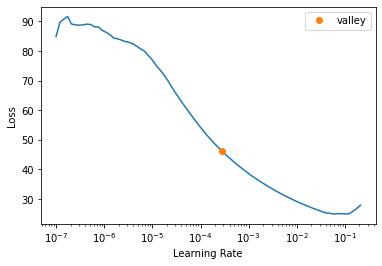

In [68]:
%%time
learn.lr_find()

In [70]:
%%time
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,2.434311,2.324295,10.219471,1:22:18


CPU times: user 55min 49s, sys: 26min 30s, total: 1h 22min 19s
Wall time: 1h 22min 18s


In [71]:
learn.save(f"gpt2-control-generation-{CATEGORY_NAME_SIMPLE}-{CODE_VER}")

Path('models/gpt2-control-generation-Automotive-v6.pth')

### [Only run after first time] Load fine-tuned model from disk

In [39]:
learn.load(f"gpt2-control-generation-{CATEGORY_NAME_SIMPLE}-{CODE_VER}")

## Run Model

### Manual Checking

In [ ]:
prompts.head(10) # Display some products that we haven't trained on

,prompt
0,"<|BOS|>Espresso Wenge Reversible L-Desk 72&quot;W with Brushed Nickel Modesty Panel Legs - At Work Collection<|SEP|>Office Furniture & Lighting,Desks & Workstations,Desks,Office Desks<|SEP|>5<|SEP|>"
1,"<|BOS|>STEELMASTER Contemporary Vertical Organizer with 4 Slots, 8.38 x 12 x 7.25 Inches, Granite (2644500A3)<|SEP|>Office Furniture & Lighting,Cabinets, Racks & Shelves,Racks & Displays<|SEP|>5<|SEP|>"
2,"<|BOS|>100 5x7 Reclosable Poly Clear Plastic Zip Lock Zipper Bag 4 Mil Jewelry Baggies<|SEP|>Office & School Supplies,Envelopes, Mailers & Shipping Supplies,Mail Bags & Transit Sacks,Mail Bags<|SEP|>5<|SEP|>"
3,<|BOS|>GLOBE-WEIS Colored Classification Folder (PU5615LBL)<|SEP|>Office & School Supplies<|SEP|>5<|SEP|>
4,"<|BOS|>3&quot; X 4&quot; - 2 Mil Clear White Block Reclosable Poly Zip Lock Bags Pack of 100<|SEP|>Office & School Supplies,Envelopes, Mailers & Shipping Supplies,Mail Bags & Transit Sacks,Mail Bags<|SEP|>5<|SEP|>"
5,"<|BOS|>Assorted Hand made Voodoo String Doll Key Chain (12 pieces)<|SEP|>Office & School Supplies,Forms, Recordkeeping & Money Handling,Key Tags & Chains<|SEP|>5<|SEP|>"
6,"<|BOS|>Vonage Phone Solution Adapter + Cordless Phone System, New for 2011 Vonage Digital Phone System Adapter and Dect 6.0 Motorola Cordless System L603 (not the previous L403) in One Box<|SEP|>Office Electronics,Telephones & Accessories,Landline Phones,Cordless Telephones<|SEP|>5<|SEP|>"
7,"<|BOS|>NEW 100 Feet Flexible Magnet Magnetic Strip 1&quot; wide Adhesive Back 30 Mil<|SEP|>Office & School Supplies,Tape, Adhesives & Fasteners,Interlocking Tape & Mounting Products,Magnetic Tape<|SEP|>5<|SEP|>"
8,"<|BOS|>Palmetto 2-Drawer Oak File Cabinet Warm Honey<|SEP|>Office & School Supplies,Forms, Recordkeeping & Money Handling,Key Cabinets, Racks & Holders,Cabinets<|SEP|>5<|SEP|>"
9,"<|BOS|>Pelikan Pelikano Blue Fountain Pen Medium<|SEP|>Office & School Supplies,Writing & Correction Supplies,Pens & Refills,Fountain Pens<|SEP|>5<|SEP|>"


In [ ]:
prompt = "<|BOS|>Espresso Wenge Reversible L-Desk 72&quot;W with Brushed Nickel Modesty Panel Legs - At Work Collection<|SEP|>Office Furniture & Lighting,Desks & Workstations,Desks,Office Desks<|SEP|>1<|SEP|>"
prompt_len = len(re.sub(r'<\|[A-Z]{3}\|>', '', prompt))

prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()

preds = learn.model.generate(inp, max_length=1024, do_sample=True, top_k=0, top_p=0.92, num_return_sequences=25, temperature=0.7)
for i, pred in enumerate(preds):
  print("{}: {}".format(i+1, tokenizer.decode(pred, skip_special_tokens=True)[prompt_len:]))

1: The legs are a bit too wide for my liking.  I got the drawer on the first floor and they are definitely not a good fit.  I am going to go back to the office supply store.  I will definitely buy again.
2: It is a HUGE piece of furniture.  It is a huge piece of junk.  It was just not worth the $30 it was charged for.  It is not worth the money.
3: The leg is too short, the hinge too tight, the hinge too loose, and the legs don't stay together.  My desk looks like it was scratched.  I'll never buy another one.
4: I had to use a hard to find regular staple tray to put in my desk, but it worked fine.  I didn't expect it to work.  I had to purchase a new one because I don't want to pay the extra $60 for a regular staple tray.  I also had to use a new staple tray because it was too heavy for my desk.  It was a total waste of money.
5: I have had this for over a year now and it has completely destroyed my desk.  The carpet is carpet, not even a single rug.  I am very happy with it.  It is n

### Generate CG/OG survey data

In [47]:
%%time

# TODO: move these to top config
NUM_OR = 200
NUM_CG = 200

NUM_RET_SEQS = 1

mixed_reviews = [] # [product name, categories, star rating, CG/OG, review text]

# The end of the regex is so complicated because reviews that actually reach 1024 tokens long will not end with EOS
regex = re.compile(
    r'<\|BOS\|>(.*?)<\|SEP\|>' + 
    r'(.*)<\|SEP\|>' * (NUM_CATEGORIES-1) +
    r'(.*)<\|SEP\|>(\d)<\|SEP\|>(?:(.*)(?:<\|EOS\|>)|(.*))', 
    re.MULTILINE | re.DOTALL
)

def add_review(review, label):
  if not regex.match(review):
    print(regex)
    print(review)

  groups = regex.match(review).groups()
  title, rating, reviewText = groups[0], groups[-3], groups[-1] if groups[-1] else groups[-2]
  categories = groups[1:-3]
  mixed_reviews.append([title, *categories, rating, label, reviewText])

# Add the OG data (which we trained on)
for review in np.random.choice(all_texts, NUM_OR, replace=False):
  # Parse review and add it to the mixed reviews
  add_review(review, 'OR')

# Add the CG data
for prompt in np.random.choice(prompts['prompt'].values, NUM_CG, replace=False):
  # Add rating section to the prompt
  rating = str(random.randint(1, 5)) # pick star rating with equal probability
  prompt += rating + SPECIAL_TOKENS['sep_token']
  
  # Generate NUM_RET_SEQS possible reviews
  prompt_ids = tokenizer.encode(prompt)
  inp = tensor(prompt_ids)[None].cuda()
  preds = learn.model.generate(inp, max_length=1024, do_sample=True, top_k=0, top_p=0.92, num_return_sequences=NUM_RET_SEQS, temperature=0.7)

  # Pick one and add it to the mixed dataset
  idx = random.randrange(NUM_RET_SEQS)
  review = tokenizer.decode(preds[idx])

  # Parse review and add it to the mixed reviews
  add_review(review, 'CG')

category_headers = [f'category_{i+1}' for i in range(NUM_CATEGORIES)]
mixed_reviews = pd.DataFrame(mixed_reviews, columns=["product", *category_headers, "rating", "label", "review"])
mixed_reviews.to_csv(f'{CATEGORY_NAME_SIMPLE}_mixed_reviews_{CODE_VER}.csv', index=None)


CPU times: user 2min 57s, sys: 606 ms, total: 2min 58s
Wall time: 3min 1s


In [ ]:
mixed_reviews.head(20)

# Misc

## Find out what GPU is being used

GPU | Time to fine tune
-|-
T4 | 20  
K80 | 85

In [18]:
!nvidia-smi

Fri Mar  4 04:36:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    27W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------